# Example 1: Shape Import

This Tutorial demonstrates how to create a connected topological network of nodes and pipes in SIR 3S via the SIR 3S Toolkit based on shape data. The data used comes from 'SIR 3S\Modelle\Beispiele\Wasser\Manual\Projektdaten\01 Shape-Dateien'.

## SIR 3S Installation

In [4]:
SIR3S_SIRGRAF_DIR = r"C:\3S Consult\Sir3S-90 Entwicklerversionen\SirGraf-90-15-00-12_Quebec_x64"

## Imports

Note: The SIR 3S Toolkit requires the Sir3S_Toolkit.dll included in SIR 3S installations (version Quebec and higher).

In [7]:
import sir3stoolkit

The core of sir3stoolkit is a Python wrapper around basic functionality of SIR 3S, offering a low-level access to the creation, modification and simulation of SIR 3S models. In the future pure python subpackages may be added.

In [9]:
from sir3stoolkit.core import wrapper

In [10]:
sir3stoolkit

<module 'sir3stoolkit' from 'C:\\Users\\aUsername.3S.000\\AppData\\Local\\anaconda3\\Lib\\site-packages\\sir3stoolkit\\__init__.py'>

The wrapper package has to be initialized with reference to a SIR 3S (SirGraf) installation.

In [12]:
wrapper.Initialize_Toolkit(SIR3S_SIRGRAF_DIR)

#### Additional imports

In [14]:
from datetime import datetime
import geopandas as gpd
import os
from shapely.geometry import LineString
import shutil

## Initialization

The SIR 3S Toolkit contains two classes: SIR3S_Model (model and data) and SIR3S_View (depiction in SIR Graf). All SIR 3S Toolkit functionality is accessed via the methods of these classes.

In [17]:
s3s = wrapper.SIR3S_Model()

Initialization complete


In [18]:
s3s_view = wrapper.SIR3S_View()

Initialization complete


Disable additional output comments of SIR 3S Toolkit methods:

In [20]:
s3s.EnableOrDisableOutputComments(outputComments=False)
s3s_view.EnableOrDisableOutputComments(outputComments=False)

## Open empty model

### Create new empty model file

In [23]:
src = r"C:\DevOps\Github_Direct_sir3stoolkit\Test\Examples\EmptyModel.XML"

In [24]:
# Generate a unique filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dst_folder = r"C:\DevOps\Github_Direct_sir3stoolkit\Test\Examples"
dst_filename = f"EmptyModelCopy_{timestamp}.XML"
dst = os.path.join(dst_folder, dst_filename)

In [25]:
# Copy the file
shutil.copy2(src, dst)

'C:\\DevOps\\Github_Direct_sir3stoolkit\\Test\\Examples\\EmptyModelCopy_20250728_141218.XML'

### Open new file

In [27]:
# Open the copied file
s3s.OpenModelXml(dst, True)

### Python Shape Import

In [29]:
fp = r"C:\3S\Modelle\Beispiele\Wasser\Manual\Projektdaten\01 Shape-Dateien\Wassernetz_Leitungen.shp"

In [30]:
gdf = gpd.read_file(fp) # Read file using gpd.read_file()

In [31]:
print(gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   3SPK        619 non-null    object  
 1   TYPE        619 non-null    object  
 2   _FROM       619 non-null    object  
 3   _TO         619 non-null    object  
 4   IDREFERENZ  619 non-null    object  
 5   DN          619 non-null    object  
 6   L           619 non-null    float64 
 7   MAT         619 non-null    object  
 8   geometry    619 non-null    geometry
dtypes: float64(1), geometry(1), object(7)
memory usage: 43.7+ KB
None


<Axes: >

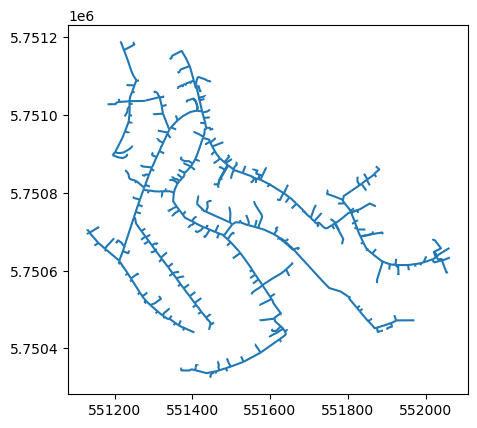

In [32]:
gdf.plot()

## Add Topology to SIR 3S

### Write node coords to dictionary

In [35]:
dictionaryNodes = {}

In [36]:
count = 0

In [37]:
for index, row in gdf.iterrows(): 
    geometry = row['geometry']
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    key = first_coord
    if not key in dictionaryNodes:
        count = count +1 
        dictionaryNodes[key] = count
        
    key = last_coord
    if not key in dictionaryNodes:
        count = count +1 
        dictionaryNodes[key] = count

### Insert nodes into SIR 3S

In [39]:
dicNodes2 = {}  

In [40]:
s3s.StartTransaction("Add Nodes")

In [41]:
for key in dictionaryNodes:
    Id = str(dictionaryNodes[key])
    text = str(key)
    coor = text.split(',')
    x = float(coor[0].replace('(',''))
    y = float(coor[1])
    z = float(coor[2].replace(')',''))
    Tk = s3s.AddNewNode("-1", Id, "QKON", x, y,z,0, 1, Id, Id, 0) 
    dicNodes2[key] = Tk  

In [42]:
s3s.EndTransaction()

### Insert Pipes into SIR 3S

In [44]:
s3s.StartTransaction("Add Pipes")

In [45]:
for index, row in gdf.iterrows(): 
    geometry = row['geometry']
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    fromNode = toNode = "-1" 
    mat = str(row["MAT"])
    DN = str(row["DN"])
    IdRef = row["IDREFERENZ"]
    
    if first_coord in dicNodes2:
        fromNode = dicNodes2[first_coord]
    if last_coord in dicNodes2:
        toNode = dicNodes2[last_coord]  
    
    lines = [xy[:2] for xy in list(geometry.coords)]
    new_p = LineString(lines)    
    
    s3s.AddNewPipe("-1", fromNode, toNode, float(row["L"]), str(new_p), mat, DN, 0.25, IdRef, row["TYPE"], 0)

In [46]:
s3s.EndTransaction()

## Save changes

In [48]:
s3s.SaveChanges()

...